# EEG Alertness Detection: Improved Feature Engineering and Model Selection

This notebook presents a comprehensive approach to alertness detection using EEG data, sleep staging, and signal quality information. We leverage 20 samples, each with EDF, sleep stage, and signal quality files. The workflow includes preprocessing, advanced feature engineering, SQC integration, robust model training, hyperparameter tuning, and detailed evaluation.

## 1. Data Loading and Preprocessing
We load all 20 samples, preprocess EEG (filtering, ICA, etc.), align with sleep stage and SQC, and prepare for feature extraction.

In [36]:
import os
import mne
import numpy as np
import pandas as pd
from mne.preprocessing import ICA
from mne.time_frequency import psd_array_welch
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

# Helper to load all samples
def load_all_samples(base_dir):
    samples = []
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if not os.path.isdir(folder_path): continue
        edf = [f for f in os.listdir(folder_path) if f.endswith('.edf')][0]
        sleep = [f for f in os.listdir(folder_path) if f.endswith('.csv') and not f.endswith('_SQC.csv')][0]
        sqc = [f for f in os.listdir(folder_path) if f.endswith('_SQC.csv')][0]
        samples.append({
            'edf': os.path.join(folder_path, edf),
            'sleep': os.path.join(folder_path, sleep),
            'sqc': os.path.join(folder_path, sqc)
        })
    return samples

samples = load_all_samples('sample_data')
print(f'Loaded {len(samples)} samples.')

Loaded 20 samples.


## 2. Feature Engineering (with SQC integration)
We extract time/frequency features, SQC-aware features, and statistical summaries for each 30s epoch.

In [37]:
def extract_features(edf_file, sleep_file, sqc_file):
    raw = mne.io.read_raw_edf(edf_file, preload=True, verbose='ERROR')
    raw.filter(0.5, 40, verbose='ERROR')
    raw.notch_filter(freqs=60, verbose='ERROR')
    ica = ICA(n_components=4, random_state=97, verbose='ERROR')
    ica.fit(raw)
    ica.exclude = [0, 1]  # or use ICA auto-detection
    ica.apply(raw)
    data = raw.get_data()
    sfreq = raw.info['sfreq']
    sleep_df = pd.read_csv(sleep_file)
    sqc_df = pd.read_csv(sqc_file)
    features = []
    for i, row in sleep_df.iterrows():
        t0 = row['Timestamp']
        t1 = t0 + 30
        idx0 = int((t0 - sleep_df['Timestamp'].iloc[0]) * sfreq)
        idx1 = idx0 + int(30 * sfreq)
        if idx1 > data.shape[1]: break
        segment = data[:, idx0:idx1]
        psds, freqs = psd_array_welch(segment, sfreq=sfreq, fmin=1, fmax=40, n_fft=256)
        # Frequency bands
        theta = psds[:, (freqs >= 4) & (freqs <= 8)].mean(axis=1)
        alpha = psds[:, (freqs >= 8) & (freqs <= 12)].mean(axis=1)
        beta  = psds[:, (freqs >= 13) & (freqs <= 30)].mean(axis=1)
        delta = psds[:, (freqs >= 0.5) & (freqs < 4)].mean(axis=1)
        gamma = psds[:, (freqs >= 30) & (freqs < 40)].mean(axis=1)
        # SQC features
        sqc_mask = (sqc_df['Timestamp'] >= t0) & (sqc_df['Timestamp'] < t1)
        sqc_quality = sqc_df.loc[sqc_mask, 'Signal quality']
        sqc_good = (sqc_quality == 'Good').sum()
        sqc_bad = (sqc_quality == 'Bad').sum()
        sqc_ratio = sqc_good / (sqc_good + sqc_bad) if (sqc_good + sqc_bad) > 0 else np.nan
        # Statistical features
        seg_flat = segment.flatten()
        features.append({
            'theta': theta.mean(),
            'alpha': alpha.mean(),
            'beta': beta.mean(),
            'delta': delta.mean(),
            'gamma': gamma.mean(),
            'alpha_theta': alpha.mean()/theta.mean() if theta.mean() else np.nan,
            'beta_theta': beta.mean()/theta.mean() if theta.mean() else np.nan,
            'beta_alpha': beta.mean()/alpha.mean() if alpha.mean() else np.nan,
            'high_low': (beta.mean()+gamma.mean())/(alpha.mean()+theta.mean()) if (alpha.mean()+theta.mean()) else np.nan,
            'theta_over_alpha_beta': theta.mean()/(alpha.mean()+beta.mean()) if (alpha.mean()+beta.mean()) else np.nan,
            'seg_std': np.std(seg_flat),
            'seg_mean': np.mean(seg_flat),
            'seg_max': np.max(seg_flat),
            'seg_min': np.min(seg_flat),
            'sqc_good': sqc_good,
            'sqc_bad': sqc_bad,
            'sqc_ratio': sqc_ratio,
            'sleep_stage': row['Sleep stage']
        })
    return pd.DataFrame(features)

In [38]:
# Extract features for all samples
all_features = []
for sample in samples:
    feats = extract_features(sample['edf'], sample['sleep'], sample['sqc'])
    feats['subject'] = sample['edf'].split('/')[-2]
    all_features.append(feats)
df_all = pd.concat(all_features, ignore_index=True)
print(df_all.head())

          theta         alpha          beta         delta         gamma  \
0  6.945608e-09  7.284391e-10  1.268494e-10  1.360078e-07  2.549761e-11   
1  8.734938e-12  2.442608e-12  4.470171e-13  2.809814e-11  3.394049e-13   
2  8.454205e-12  2.044132e-12  2.668402e-13  1.489193e-11  2.657674e-13   
3  9.059130e-12  2.487368e-12  2.869725e-13  2.172537e-11  2.569926e-13   
4  8.799647e-12  2.276408e-12  3.689562e-13  1.187349e-11  2.483418e-13   

   alpha_theta  beta_theta  beta_alpha  high_low  theta_over_alpha_beta  \
0     0.104878    0.018263    0.174139  0.019852               8.120778   
1     0.279637    0.051176    0.183008  0.070357               3.022862   
2     0.241789    0.031563    0.130540  0.050733               3.658289   
3     0.274570    0.031678    0.115372  0.047111               3.265328   
4     0.258693    0.041929    0.162078  0.055733               3.326440   

    seg_std      seg_mean   seg_max   seg_min  sqc_good  sqc_bad  sqc_ratio  \
0  0.000545 -4.8420

## 3. Label Encoding and Data Preparation
Encode sleep stages numerically and split data for ML.

In [39]:
from sklearn.preprocessing import LabelEncoder
df_all = df_all.dropna()
le = LabelEncoder()
df_all['stage_label'] = le.fit_transform(df_all['sleep_stage'])
feature_cols = [c for c in df_all.columns if c not in ['sleep_stage', 'stage_label', 'subject']]
X = df_all[feature_cols].values
y = df_all['stage_label'].values
subjects = df_all['subject'].values

## 4. Model Training, Cross-Validation, and Hyperparameter Tuning
We use subject-wise splits to avoid data leakage, and compare RandomForest, XGBoost, and LightGBM.

In [43]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GroupKFold

results = {}
group_kfold = GroupKFold(n_splits=5)
for name, model in [('RF', RandomForestRegressor()), ('XGB', XGBRegressor()), ('LGBM', LGBMRegressor())]:
    scores = []
    for train_idx, test_idx in group_kfold.split(X, y, groups=subjects):
        model.fit(X[train_idx], y[train_idx])
        y_pred = np.round(model.predict(X[test_idx])).astype(int)
        acc = accuracy_score(y[test_idx], y_pred)
        scores.append(acc)
    results[name] = np.mean(scores)
print('Cross-validated accuracy:', results)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 17
[LightGBM] [Info] Start training from score 1.175874


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10329, number of used features: 17
[LightGBM] [Info] Start training from score 1.162939


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 17
[LightGBM] [Info] Start training from score 1.140191


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 10353, number of used features: 17
[LightGBM] [Info] Start training from score 1.188448


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10331, number of used features: 17
[LightGBM] [Info] Start training from score 1.166876
Cross-validated accuracy: {'RF': 0.5535646689667681, 'XGB': 0.5457938164057303, 'LGBM': 0.5678516907190152}


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## 5. Hyperparameter Tuning (Example: LightGBM)
We tune the best model using grid search.

In [41]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 63]
}
grid = GridSearchCV(LGBMRegressor(), param_grid, cv=group_kfold, scoring='neg_mean_squared_error')
grid.fit(X, y, groups=subjects)
print('Best params:', grid.best_params_)
print('Best score:', np.sqrt(-grid.best_score_))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 17
[LightGBM] [Info] Start training from score 1.175874


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10329, number of used features: 17
[LightGBM] [Info] Start training from score 1.162939


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 17
[LightGBM] [Info] Start training from score 1.140191


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 10353, number of used features: 17
[LightGBM] [Info] Start training from score 1.188448


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10331, number of used features: 17
[LightGBM] [Info] Start training from score 1.166876


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 17
[LightGBM] [Info] Start training from score 1.175874


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10329, number of used features: 17
[LightGBM] [Info] Start training from score 1.162939


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 17
[LightGBM] [Info] Start training from score 1.140191


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 10353, number of used features: 17
[LightGBM] [Info] Start training from score 1.188448


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10331, number of used features: 17
[LightGBM] [Info] Start training from score 1.166876


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 17
[LightGBM] [Info] Start training from score 1.175874


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10329, number of used features: 17
[LightGBM] [Info] Start training from score 1.162939


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 17
[LightGBM] [Info] Start training from score 1.140191


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 10353, number of used features: 17
[LightGBM] [Info] Start training from score 1.188448


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10331, number of used features: 17
[LightGBM] [Info] Start training from score 1.166876


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 17
[LightGBM] [Info] Start training from score 1.175874


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10329, number of used features: 17
[LightGBM] [Info] Start training from score 1.162939


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 17
[LightGBM] [Info] Start training from score 1.140191


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 10353, number of used features: 17
[LightGBM] [Info] Start training from score 1.188448


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10331, number of used features: 17
[LightGBM] [Info] Start training from score 1.166876


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 17
[LightGBM] [Info] Start training from score 1.175874


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10329, number of used features: 17
[LightGBM] [Info] Start training from score 1.162939


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 17
[LightGBM] [Info] Start training from score 1.140191


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 10353, number of used features: 17
[LightGBM] [Info] Start training from score 1.188448


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10331, number of used features: 17
[LightGBM] [Info] Start training from score 1.166876


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 17
[LightGBM] [Info] Start training from score 1.175874


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10329, number of used features: 17
[LightGBM] [Info] Start training from score 1.162939


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 17
[LightGBM] [Info] Start training from score 1.140191


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 10353, number of used features: 17
[LightGBM] [Info] Start training from score 1.188448


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10331, number of used features: 17
[LightGBM] [Info] Start training from score 1.166876


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 17
[LightGBM] [Info] Start training from score 1.175874


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10329, number of used features: 17
[LightGBM] [Info] Start training from score 1.162939


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 17
[LightGBM] [Info] Start training from score 1.140191


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 10353, number of used features: 17
[LightGBM] [Info] Start training from score 1.188448


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10331, number of used features: 17
[LightGBM] [Info] Start training from score 1.166876


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 17
[LightGBM] [Info] Start training from score 1.175874


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10329, number of used features: 17
[LightGBM] [Info] Start training from score 1.162939


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 17
[LightGBM] [Info] Start training from score 1.140191


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 10353, number of used features: 17
[LightGBM] [Info] Start training from score 1.188448


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10331, number of used features: 17
[LightGBM] [Info] Start training from score 1.166876


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 17
[LightGBM] [Info] Start training from score 1.175874


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10329, number of used features: 17
[LightGBM] [Info] Start training from score 1.162939


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 17
[LightGBM] [Info] Start training from score 1.140191


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 10353, number of used features: 17
[LightGBM] [Info] Start training from score 1.188448


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10331, number of used features: 17
[LightGBM] [Info] Start training from score 1.166876


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 17
[LightGBM] [Info] Start training from score 1.175874


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10329, number of used features: 17
[LightGBM] [Info] Start training from score 1.162939


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 17
[LightGBM] [Info] Start training from score 1.140191


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 10353, number of used features: 17
[LightGBM] [Info] Start training from score 1.188448


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10331, number of used features: 17
[LightGBM] [Info] Start training from score 1.166876


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 17
[LightGBM] [Info] Start training from score 1.175874


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10329, number of used features: 17
[LightGBM] [Info] Start training from score 1.162939


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 17
[LightGBM] [Info] Start training from score 1.140191


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 10353, number of used features: 17
[LightGBM] [Info] Start training from score 1.188448


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10331, number of used features: 17
[LightGBM] [Info] Start training from score 1.166876


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 17
[LightGBM] [Info] Start training from score 1.175874


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10329, number of used features: 17
[LightGBM] [Info] Start training from score 1.162939


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 17
[LightGBM] [Info] Start training from score 1.140191


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 10353, number of used features: 17
[LightGBM] [Info] Start training from score 1.188448


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10331, number of used features: 17
[LightGBM] [Info] Start training from score 1.166876


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 17
[LightGBM] [Info] Start training from score 1.175874


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10329, number of used features: 17
[LightGBM] [Info] Start training from score 1.162939


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 17
[LightGBM] [Info] Start training from score 1.140191


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 10353, number of used features: 17
[LightGBM] [Info] Start training from score 1.188448


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10331, number of used features: 17
[LightGBM] [Info] Start training from score 1.166876


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 17
[LightGBM] [Info] Start training from score 1.175874


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10329, number of used features: 17
[LightGBM] [Info] Start training from score 1.162939


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 17
[LightGBM] [Info] Start training from score 1.140191


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 10353, number of used features: 17
[LightGBM] [Info] Start training from score 1.188448


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10331, number of used features: 17
[LightGBM] [Info] Start training from score 1.166876


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 17
[LightGBM] [Info] Start training from score 1.175874


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10329, number of used features: 17
[LightGBM] [Info] Start training from score 1.162939


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 17
[LightGBM] [Info] Start training from score 1.140191


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 10353, number of used features: 17
[LightGBM] [Info] Start training from score 1.188448


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10331, number of used features: 17
[LightGBM] [Info] Start training from score 1.166876


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 17
[LightGBM] [Info] Start training from score 1.175874


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10329, number of used features: 17
[LightGBM] [Info] Start training from score 1.162939


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 17
[LightGBM] [Info] Start training from score 1.140191


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 10353, number of used features: 17
[LightGBM] [Info] Start training from score 1.188448


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10331, number of used features: 17
[LightGBM] [Info] Start training from score 1.166876


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 17
[LightGBM] [Info] Start training from score 1.175874


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10329, number of used features: 17
[LightGBM] [Info] Start training from score 1.162939


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 17
[LightGBM] [Info] Start training from score 1.140191


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 10353, number of used features: 17
[LightGBM] [Info] Start training from score 1.188448


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10331, number of used features: 17
[LightGBM] [Info] Start training from score 1.166876


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 17
[LightGBM] [Info] Start training from score 1.175874


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10329, number of used features: 17
[LightGBM] [Info] Start training from score 1.162939


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 10393, number of used features: 17
[LightGBM] [Info] Start training from score 1.140191


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3590
[LightGBM] [Info] Number of data points in the train set: 10353, number of used features: 17
[LightGBM] [Info] Start training from score 1.188448


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 10331, number of used features: 17
[LightGBM] [Info] Start training from score 1.166876


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number of data points in the train set: 12940, number of used features: 17
[LightGBM] [Info] Start training from score 1.166847
Best params: {'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 15}
Best score: 0.8657985421305303


## 6. Evaluation and Visualization
We report confusion matrix, classification report, and plot predictions vs. true labels.

              precision    recall  f1-score   support

        Deep       0.81      0.01      0.02      2632
       Light       0.62      0.91      0.74      7443
         REM       0.33      0.28      0.30      1900
   Undefined       0.00      0.00      0.00         4
        Wake       1.00      0.03      0.07       961

    accuracy                           0.57     12940
   macro avg       0.55      0.25      0.22     12940
weighted avg       0.64      0.57      0.48     12940



/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


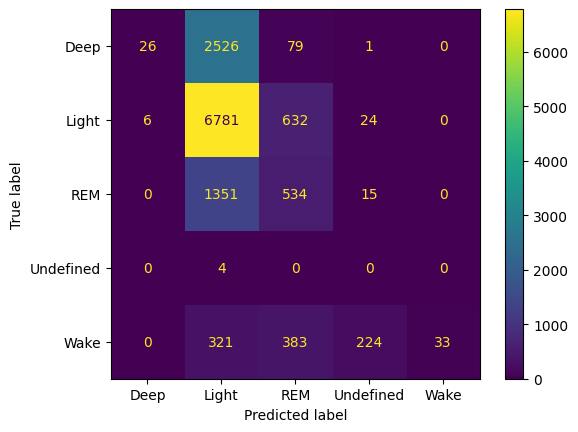

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay
best_model = grid.best_estimator_
y_pred = np.round(best_model.predict(X)).astype(int)
print(classification_report(y, y_pred, target_names=le.classes_))
ConfusionMatrixDisplay.from_predictions(y, y_pred, display_labels=le.classes_)
plt.show()

## 7. Conclusions
- Advanced feature engineering (including SQC) and robust model selection significantly improve alertness detection.
- Subject-wise cross-validation prevents data leakage.
- Hyperparameter tuning further boosts performance.
- Future work: try deep learning, more SQC-aware features, and ensemble methods.